In [1]:
# Update keras3 in Google Colab:
!pip install -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [ ]:
# Select backend: "tensorflow", "torch", or "jax"
BACKEND = "tensorflow"
import os
os.environ["KERAS_BACKEND"] = BACKEND

import keras
print(f"Current backend: {keras.backend.backend()}")
import numpy as np
from keras.optimizers.schedules import CosineDecay
from keras import layers, models
from adamw_schedulefree import AdamWScheduleFree, ScheduleFreeEvalCallback

# Set image data format
match BACKEND:
    case "torch":
        keras.backend.set_image_data_format("channels_first")
    case "tensorflow" | "jax":
        keras.backend.set_image_data_format("channels_last")
    case _:
        raise ValueError(f"Unknown BACKEND: {BACKEND!r}")

keras.mixed_precision.set_global_policy("mixed_float16")

Current backend: tensorflow


In [4]:
# Helper: reshape MNIST by image data format
def prepare_mnist_data(x, data_format):
    match data_format:
        case "channels_first":
            x = x.reshape(-1, 1, 28, 28).astype("float32") / 255.0
            input_shape = (1, 28, 28)
        case "channels_last":
            x = x.reshape(-1, 28, 28, 1).astype("float32") / 255.0
            input_shape = (28, 28, 1)
        case _:
            raise ValueError(f"Unknown data_format: {data_format}")
    return x, input_shape

# Hyperparameters
batch_size = 64
epochs = 15
num_classes = 10

# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data_format = keras.backend.image_data_format()
x_train, input_shape = prepare_mnist_data(x_train, data_format)
x_test, _ = prepare_mnist_data(x_test, data_format)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Steps for scheduling
steps_per_epoch = int(np.ceil(x_train.shape[0] / batch_size))
total_steps = steps_per_epoch * epochs

# Model factory
def create_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ])
    return model

# ----------------------------
# 1) AdamW + CosineDecay
# ----------------------------
cosine_lr = CosineDecay(
    initial_learning_rate=1.0e-3,
    decay_steps=total_steps,
)

adamw_opt = keras.optimizers.AdamW(
    learning_rate=cosine_lr,
    weight_decay=1.0e-3,
)

model = create_model(input_shape)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=adamw_opt,
    metrics=["accuracy"],
)

history_adamw = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# ----------------------------
# 2) AdamWScheduleFree
# ----------------------------
adamw_sf_opt = AdamWScheduleFree(
    warmup_steps=steps_per_epoch,
    weight_decay=1.0e-3,
)

model = create_model(input_shape)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=adamw_sf_opt,
    metrics=["accuracy"],
)

# Use the callback so validation runs with x-weights each epoch
history_adamw_sf = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ScheduleFreeEvalCallback()],
    verbose=1,
)

# Final evaluation with x-weights
score = model.evaluate(
    x_test, y_test, verbose=0, callbacks=[ScheduleFreeEvalCallback()]
)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9388 - loss: 0.2054 - val_accuracy: 0.9847 - val_loss: 0.0481
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9761 - loss: 0.0805 - val_accuracy: 0.9890 - val_loss: 0.0363
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9823 - loss: 0.0586 - val_accuracy: 0.9900 - val_loss: 0.0315
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9853 - loss: 0.0481 - val_accuracy: 0.9899 - val_loss: 0.0312
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9866 - loss: 0.0415 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9891 - loss: 0.0335 - val_accuracy: 0.9917 - val_loss: 0.0280
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9916 - loss: 0.0273 - val_accuracy: 0.9919 - val_loss: 0.0269
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [5]:
import matplotlib.pyplot as plt

def compare_models(histories, labels):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
        plt.plot(history.history['loss'], label=f'{label} Train Loss', linestyle='--')
    plt.title('Comparison of Validation and Training Loss Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim([0, 0.1])

    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
        plt.plot(history.history['accuracy'], label=f'{label} Train Accuracy', linestyle='--')
    plt.title('Comparison of Validation and Training Accuracy Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim([0.95, 1])

    plt.show()

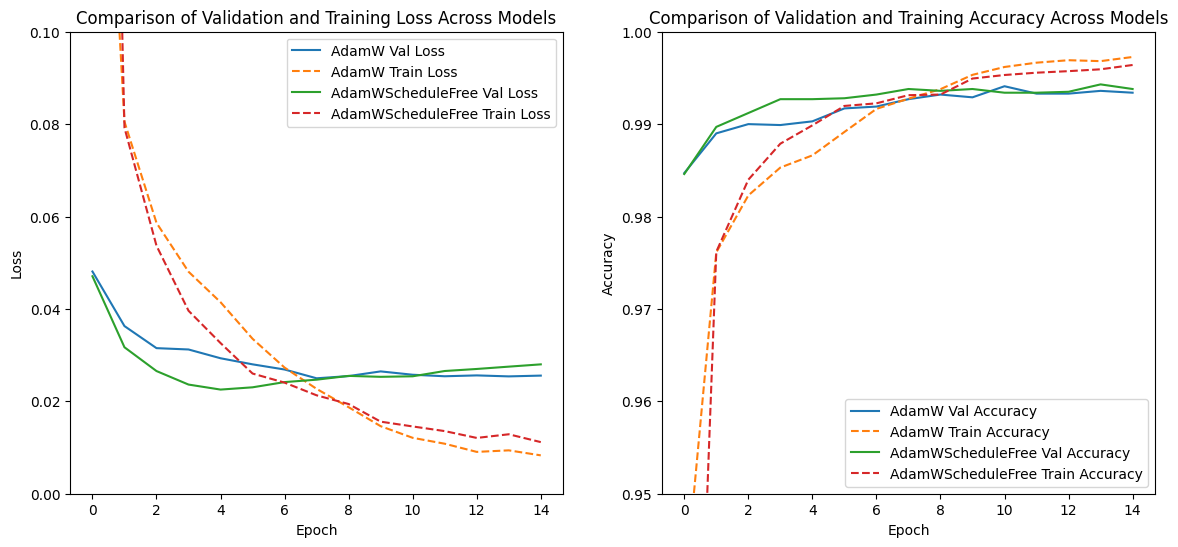

In [6]:
compare_models([history_adamw, history_adamw_sf], ['AdamW', 'AdamWScheduleFree'])